 # IEEE-CIS Fraud Detection

Vesta Corporation provided the dataset for this model. Vesta Corporation is the forerunner in guaranteed e-commerce payment solutions. Founded in 1995, Vesta pioneered the process of fully guaranteed card-not-present (CNP) payment transactions for the telecommunications industry. Since then, Vesta has firmly expanded data science and machine learning capabilities across the globe and solidified its position as the leader in guaranteed ecommerce payments. Today, Vesta guarantees more than $18B in transactions annually. 

Problem: Binary classification with a heavy dataset imbalance

## Objective: Detect fraud in Transactions

### Data:  
  
``isFraud`` is the binary that denotes whether a transaction is fraud or not and this is the dependent variable to be modeled for  

Data is broken into two files ***identity*** and ***transaction***, these can be join by the ``TransactioID``  
  
***Identity Categorical Features***
* DeviceType
* DeviceInfo
* id_12-id_38
  
***Transaction Categorical Features***
* Product CD
* emaildomain
* card1-card6
* addr1, addr2
* P_emaildomain
* R_emaildomain
* M1-M9

The ``TransactionDT`` feature is a timedelta from a given reference datetime (not an actual timestamp).


## Import Required Modules

In [1]:
import numpy as np
import pandas as pd
import gc
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import itertools

from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.model_selection import train_test_split, GroupKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample
from sklearn.model_selection import RandomizedSearchCV
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import classification_report
from catboost.utils import get_roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import warnings
warnings.filterwarnings('ignore')


# special IPython command to prepare the notebook for matplotlib and other libraries
%matplotlib inline 

In [2]:
# Functions

# From kernel https://www.kaggle.com/gemartin/load-data-reduce-memory-usage
# WARNING! THIS CAN DAMAGE THE DATA 
def reduce_mem_usage2(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

def build_roc(target_test,test_preds):
    fpr, tpr, threshold = roc_curve(target_test, test_preds)
    
    # plot the no skill line
    plt.plot([0, 1], [0, 1], linestyle='--')
    
    # plot the ro curve 
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc = 'lower right')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    
def make_classification_report(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
    disp.plot()
    plt.show()
    
    target_names = y.unique().tolist()
    for i in range(len(target_names)):
        target_names[i] = str(target_names[i])
    print(classification_report(y_test, y_pred, target_names=target_names))

def plot_feature_importance(clf, training_set: pd.DataFrame):
    feature_imp = pd.DataFrame(sorted(zip(clf.feature_importances_, training_set.columns)), columns=['Value','Feature'])
    plt.figure(figsize=(20, 10))
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False).iloc[:30])
    plt.title('XGB Most Important Features')
    plt.tight_layout()
    plt.show()

## Load the Dataset

In [3]:
FOLDER_PATH = '../data'
train_identity = pd.read_csv(f'{FOLDER_PATH}/train_identity.csv.zip')
train_transaction = pd.read_csv(f'{FOLDER_PATH}/train_transaction.csv.zip')
test_identity = pd.read_csv(f'{FOLDER_PATH}/test_identity.csv.zip')
test_transaction = pd.read_csv(f'{FOLDER_PATH}/test_transaction.csv')

In [4]:
# merge the testing and training data
train = pd.merge(train_transaction, train_identity, on='TransactionID', how='left')
test = pd.merge(test_transaction, test_identity, on='TransactionID', how='left')

In [5]:
print(f'Transaction df shape: {train_transaction.shape}')
train_transaction.head()

Transaction df shape: (590540, 394)


,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
print(f'Identity df shape: {train_identity.shape}')
train_identity.head()

Identity df shape: (144233, 41)


,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,...,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2,2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
3,2987011,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
4,2987016,0.0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,...,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS


In [7]:
del train_identity, train_transaction, test_identity, test_transaction

## Exploratory Data Analysis

Click [here](https://github.com/JoshSpangler96/IEEE-CIS-Fraud-Detection/blob/main/IEEE_Fraud_Detection_EDA.ipynb) to view the EDA I performed for this dataset \
\
Key takeaways from EDA: 
* Highly imbalanced dataset with 3.5% fraud
* Train data and test data are seperated by time. Need time based split for validation set
* Ff the 415 features in the V, C, D, M, and ID categories there are 136 uncorrelated useful features
* Highest precentage of Fraud happens early morning

In [8]:
test.columns = test.columns.str.replace('[-]', '_')

In [9]:
# Keep only the useful columns from the EDA
features_to_use = [
    'TransactionID', 'TransactionDT', 'TransactionAmt', 
    'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'DeviceType', 
    'DeviceInfo', 'addr1', 'addr2', 'dist1', 'dist2', 'P_emaildomain', 'R_emaildomain', 
    'V147', 'V142', 'V1', 'V174', 'V109', 'V201', 'V238', 'V271', 'V78', 
    'V160', 'V65', 'V339', 'V27', 'V138', 'V320', 'V6', 'V223', 'V114', 
    'V118', 'V173', 'V80', 'V107', 'V258', 'V44', 'V198', 'V252', 'V220', 
    'V309', 'V209', 'V67', 'V124', 'V260', 'V155', 'V176', 'V55', 'V36', 
    'V325', 'V127', 'V175', 'V82', 'V20', 'V329', 'V111', 'V139', 'V210', 
    'V30', 'V86', 'V3', 'V37', 'V13', 'V207', 'V286', 'V47', 'V162', 'V8', 
    'V62', 'V234', 'V56', 'V240', 'V23', 'V4', 'V115', 'V166', 'V121', 'V76', 
    'V259', 'V312', 'V120', 'V169', 'V305', 'V291', 'V185', 'V26', 'V241', 
    'V250', 'V108', 'V261', 'V54', 'D5', 'D14', 'D1', 'D9', 'D13', 'D8', 
    'D15', 'D10', 'C1', 'C5', 'C3', 'M5', 'M7', 'M4', 'M2', 'M9', 'M6', 
    'M1', 'M3', 'M8', 'id_08', 'id_09', 'id_28', 'id_07', 'id_37', 'id_01', 
    'id_27', 'id_25', 'id_21', 'id_12', 'id_38', 'id_35', 'id_30', 'id_04', 
    'id_05', 'id_29', 'id_36', 'id_34', 'id_11', 'id_26', 'id_13', 'id_24', 
    'id_23', 'id_20', 'id_17', 'id_14', 'id_31', 'id_32', 'id_03', 'id_10', 
    'id_18', 'id_02', 'id_06', 'id_16', 'id_15', 'id_19', 'id_33', 'id_22']

#reduce both test and train
print(f'Datasets have {len(train.columns)} features before reduction')
train_features = features_to_use + ['isFraud']
train = train[train_features]
test = test[features_to_use]
print(f'Datasets have {len(train.columns)} features after reduction')

Datasets have 434 features before reduction
Datasets have 155 features after reduction


## Feature Engineering

In [10]:
START_DATE = '2017-12-01'
startdate = datetime.datetime.strptime(START_DATE, "%Y-%m-%d")

datasets = [train, test]
for data in datasets:
    data['cents'] = (data['TransactionAmt'] - np.floor(data['TransactionAmt'])).astype('float32')
    data['log_TransactionAmt'] = np.log(data['TransactionAmt'])
    data[['P_email_1', 'P_email_2', 'P_email_3']] = data['P_emaildomain'].str.split('.', expand=True)
    data.drop('P_emaildomain', axis=1, inplace=True)
    data[['R_email_1', 'R_email_2', 'R_email_3']] = data['R_emaildomain'].str.split('.', expand=True)
    data.drop('R_emaildomain', axis=1, inplace=True)
    data['Date'] = data['TransactionDT'].apply(lambda x: (startdate + datetime.timedelta(seconds=x)))
    data['Weekdays'] = data['Date'].dt.dayofweek
    data['Hours'] = data['Date'].dt.hour
    data['Days'] = data['Date'].dt.day
    data['Month'] = (data['Date'].dt.year-2017)*12 + data['Date'].dt.month
    
    # Aggregate features together
    data['uid'] = data['card1'].astype(str)+'_'+data['addr1'].astype(str)
    data['uid2'] = data['uid'].astype(str)+'_'+np.floor(data.Days-data.D1).astype(str)
    for feature in ['TransactionAmt', 'D9', 'D10', 'C1', 'C5']:
        for agg in ['mean', 'std']:
            temp = data.groupby(['uid2'])[feature].agg([agg]).reset_index().rename(columns={f'{agg}': f'{feature}_{agg}_uid'})
            temp.index = list(temp['uid2'])
            temp = temp[f'{feature}_{agg}_uid'].to_dict()
            data[f'{feature}_{agg}_uid'] = data['uid2'].map(temp).astype('float32')
    data.drop('uid2', axis=1, inplace=True)
    
    for feature in ['card1', 'card4']:
        for agg in ['mean', 'std']:
            data[f'TransactionAmt_{agg}_{feature}'] = data['TransactionAmt'] / data.groupby([feature])['TransactionAmt'].transform(agg)
            data[f'id_01_{agg}_{feature}'] = data['TransactionAmt'] / data.groupby([feature])['id_01'].transform(agg)
    
    
print(f'Datasets have {len(train.columns)} features after feature engineering')

Datasets have 185 features after feature engineering


## Prepare for Modeling

***Categorical Feature Encoding***

In [11]:
# get a list of all categorical features in the datasets
d_type = pd.DataFrame(train.dtypes)
d_type.rename({0: 'dtype'}, axis=1,  inplace=True)
d_type.reset_index(inplace=True)
d_type['dtype'] = d_type['dtype'].astype('string')
cat_col = d_type.loc[(d_type['dtype'] == 'object')]['index'].to_list()

print(cat_col)

['ProductCD', 'card4', 'card6', 'DeviceType', 'DeviceInfo', 'M5', 'M7', 'M4', 'M2', 'M9', 'M6', 'M1', 'M3', 'M8', 'id_28', 'id_37', 'id_27', 'id_12', 'id_38', 'id_35', 'id_30', 'id_29', 'id_36', 'id_34', 'id_23', 'id_31', 'id_16', 'id_15', 'id_33', 'P_email_1', 'P_email_2', 'P_email_3', 'R_email_1', 'R_email_2', 'R_email_3', 'uid']


In [12]:
# Add categorical features that are not objects 
# Listed in the data overview section of the Kaggle competition
card_cat = [f'card{x}' for x in range(1,7)]
addr_cat = [f'addr{x}' for x in range(1,3)]
id_cat = [f'id_{x}' for x in range(12,39)]
cat_col += card_cat + addr_cat + id_cat
cat_col = list(set(cat_col))

In [13]:
for i in range(len(cat_col)):
    if cat_col[i] in train.columns:
        le = LabelEncoder()
        le.fit(list(train[cat_col[i]].astype(str).values) + list(test[cat_col[i]].astype(str).values))
        train[cat_col[i]] = le.transform(list(train[cat_col[i]].astype(str).values))
        test[cat_col[i]] = le.transform(list(test[cat_col[i]].astype(str).values))   

***Clean Missing Values***

In [14]:
train.replace([np.inf, -np.inf], np.nan, inplace=True)
test.replace([np.inf, -np.inf], np.nan, inplace=True)

In [15]:
# train.fillna(train.median(), inplace=True)
# test.fillna(test.median(), inplace=True)
train.fillna(-1, inplace=True)
test.fillna(-1, inplace=True)

***Reduce Memory Usage***

In [16]:
# set up X train and y train
X = train.sort_values('TransactionDT').drop(['isFraud', 'TransactionDT', 'Date'], axis=1)
y = train.sort_values('TransactionDT')['isFraud']
test = test.sort_values('TransactionDT').drop(['TransactionDT', 'Date'], axis=1)

In [17]:
# reduce the memory usage
X = reduce_mem_usage2(X)

Memory usage of dataframe is 678.07 MB
Memory usage after optimization is: 193.73 MB
Decreased by 71.4%


In [18]:
del train
gc.collect()

29

### Modeling

In [20]:
from imblearn.over_sampling import SMOTE

smote = SMOTE()
X_sm, y_sm = smote.fit_resample(X, y)

In [21]:
# # Parameter grid for lgb
# params = {
#     'learning_rate': [0.01, 0.02],
#     'min_child_weight': [0.001, 0.01],
#     'colsample_bytree': [0.5, 0.7],
#     'num_leaves': [256, 512],
#     'feature_fraction': [0.5, 0.75],
#     'bagging_fraction': [0.5, 0.75],
#     'reg_alpha': [0.4, 0.6],
#     'reg_lambda': [0.4, 0.6],
# }

# lgb_clf = lgb.LGBMClassifier(
#     learning_rate=0.02, 
#     n_estimators=600, 
#     objective='binary',
#     metric= 'auc',
#     n_jobs = -1
# )

# param_comb = 5

# clf = RandomizedSearchCV(
#     lgb_clf, 
#     param_distributions=params,         
#     n_iter=param_comb, scoring='roc_auc',             
#     n_jobs=4, 
#     cv=3
# )

# clf.fit(X_sm, y_sm, verbose=200, eval_set=[(X_test, y_test)])

# print('\n Best hyperparameters:')
# print(clf.best_params_)
# print('\n Best estimator:')
# print(clf.best_estimator_)

In [22]:
# Obtained through RandomSearchCV
hyper_parameters = {
    'num_leaves': 512, 
    'min_child_weight': 0.001,
    'feature_fraction': 0.5, 
    'bagging_fraction': 0.75,
    'min_data_in_leaf': 106,
    'objective': 'binary',
    'learning_rate': 0.02, 
    'boosting_type': 'gbdt',
    'metric': 'auc',
    "verbosity": -1,
    'reg_lambda': 0.4, 
    'reg_alpha': 0.6, 
}

Training on fold 1 (Withholding Month: 12)
Train size: 913430 Test Size: 226324
Training until validation scores don't improve for 200 rounds
[200]	training's auc: 0.99794	valid_1's auc: 0.992719
[400]	training's auc: 0.999592	valid_1's auc: 0.994208
[600]	training's auc: 0.999966	valid_1's auc: 0.994613
[800]	training's auc: 0.999998	valid_1's auc: 0.994531
Early stopping, best iteration is:
[617]	training's auc: 0.999974	valid_1's auc: 0.994623
Out of fold Prediction Size: 226324


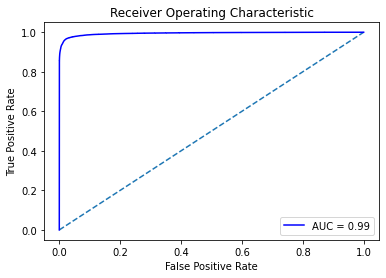

Training on fold 2 (Withholding Month: 15)
Train size: 930502 Test Size: 209252
Training until validation scores don't improve for 200 rounds
[200]	training's auc: 0.997943	valid_1's auc: 0.993338
[400]	training's auc: 0.999597	valid_1's auc: 0.994846
[600]	training's auc: 0.999969	valid_1's auc: 0.99496
Early stopping, best iteration is:
[519]	training's auc: 0.999903	valid_1's auc: 0.995028
Out of fold Prediction Size: 209252


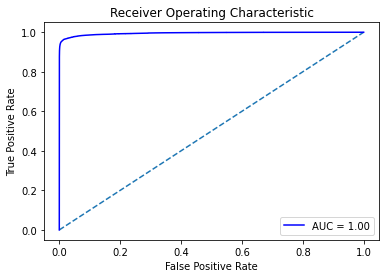

Training on fold 3 (Withholding Month: 13)
Train size: 949208 Test Size: 190546
Training until validation scores don't improve for 200 rounds
[200]	training's auc: 0.997804	valid_1's auc: 0.994325
[400]	training's auc: 0.999548	valid_1's auc: 0.995878
[600]	training's auc: 0.999959	valid_1's auc: 0.996058
Early stopping, best iteration is:
[544]	training's auc: 0.999913	valid_1's auc: 0.996073
Out of fold Prediction Size: 190546


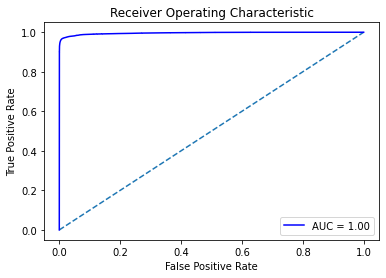

Training on fold 4 (Withholding Month: 14)
Train size: 957440 Test Size: 182314
Training until validation scores don't improve for 200 rounds
[200]	training's auc: 0.997813	valid_1's auc: 0.995024
[400]	training's auc: 0.999527	valid_1's auc: 0.996224
[600]	training's auc: 0.999949	valid_1's auc: 0.996429
[800]	training's auc: 0.999997	valid_1's auc: 0.99646
Early stopping, best iteration is:
[728]	training's auc: 0.999991	valid_1's auc: 0.996485
Out of fold Prediction Size: 182314


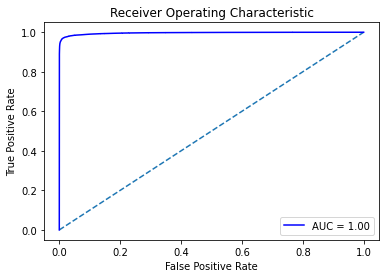

Training on fold 5 (Withholding Month: 16)
Train size: 808436 Test Size: 331318
Training until validation scores don't improve for 200 rounds
[200]	training's auc: 0.99806	valid_1's auc: 0.990955
[400]	training's auc: 0.999695	valid_1's auc: 0.99325
[600]	training's auc: 0.999985	valid_1's auc: 0.99373
[800]	training's auc: 1	valid_1's auc: 0.993805
[1000]	training's auc: 1	valid_1's auc: 0.993851
[1200]	training's auc: 1	valid_1's auc: 0.993871
[1400]	training's auc: 1	valid_1's auc: 0.993924
[1600]	training's auc: 1	valid_1's auc: 0.993937
[1800]	training's auc: 1	valid_1's auc: 0.993912
Early stopping, best iteration is:
[1628]	training's auc: 1	valid_1's auc: 0.993942
Out of fold Prediction Size: 331318


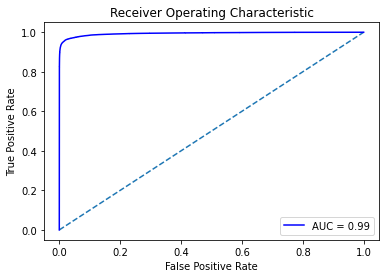

--------------------------------------------------
Mean AUC: 0.9952302725834887
--------------------------------------------------


In [26]:
folds = GroupKFold(n_splits=5)

y_oof = np.zeros(y_sm.shape[0])
y_test_pred = np.zeros(test.shape[0])

# weights = y.value_counts(normalize = True).min() / y.value_counts(normalize = True)
# train_weights = pd.DataFrame(y.rename('old_target')).merge(
#     weights, 
#     how = 'left', 
#     left_on = 'old_target', 
#     right_on = weights.index)['isFraud'].values

aucs = list()
feature_importances = pd.DataFrame()
feature_importances['feature'] = X.columns

for fold, (trn_idx, test_idx) in enumerate(folds.split(X_sm, y_sm, groups=X_sm['Month'])):
    month = X_sm.iloc[test_idx]['Month'].iloc[0]
    print(f'Training on fold {fold + 1} (Withholding Month: {month})')
    print(f'Train size: {len(trn_idx)} Test Size: {len(test_idx)}')

    trn_data = lgb.Dataset(X_sm.iloc[trn_idx], label=y_sm.iloc[trn_idx], 
#                            weight=train_weights[trn_idx]
                          )
    val_data = lgb.Dataset(X_sm.iloc[test_idx], label=y_sm.iloc[test_idx], 
#                           weight=train_weights[test_idx]
                          )

    clf = lgb.train(
        hyper_parameters, 
        trn_data, 10000, 
        valid_sets = [trn_data, val_data], 
        verbose_eval=200, 
        early_stopping_rounds=200
    )
    
    # predict validation
    y_pred = clf.predict(X_sm.iloc[test_idx])
    y_oof[test_idx] = y_pred
    
    # predict test
    y_test_pred += clf.predict(test) / folds.n_splits
    
    print(f'Out of fold Prediction Size: {len(y_pred)}')
    build_roc(y_sm[test_idx], y_pred)

    feature_importances[f'fold_{fold + 1}'] = clf.feature_importance()
    aucs.append(clf.best_score['valid_1']['auc'])

print('-' * 50)
print('Mean AUC:', np.mean(aucs))
print('-' * 50)

Training Set Classification Report


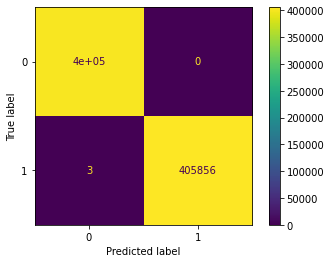

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    402577
           1       1.00      1.00      1.00    405859

    accuracy                           1.00    808436
   macro avg       1.00      1.00      1.00    808436
weighted avg       1.00      1.00      1.00    808436

Validation Set Classification Report


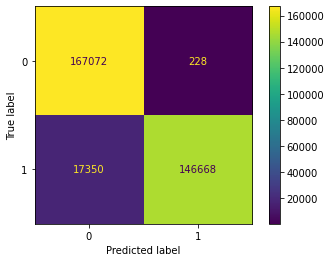

              precision    recall  f1-score   support

           0       0.91      1.00      0.95    167300
           1       1.00      0.89      0.94    164018

    accuracy                           0.95    331318
   macro avg       0.95      0.95      0.95    331318
weighted avg       0.95      0.95      0.95    331318



In [36]:
print('Training Set Classification Report')
threshold = 0.75
y_train_pred = (clf.predict(X_sm.iloc[trn_idx]) > threshold).astype('float')
make_classification_report(y_test=y_sm.iloc[trn_idx], y_pred=y_train_pred)
print('Validation Set Classification Report')
y_val_pred = (y_pred > threshold).astype('float')
make_classification_report(y_test=y_sm.iloc[test_idx], y_pred=y_val_pred)

Text(0.5, 1.0, 'LightGBM Feature Importance')

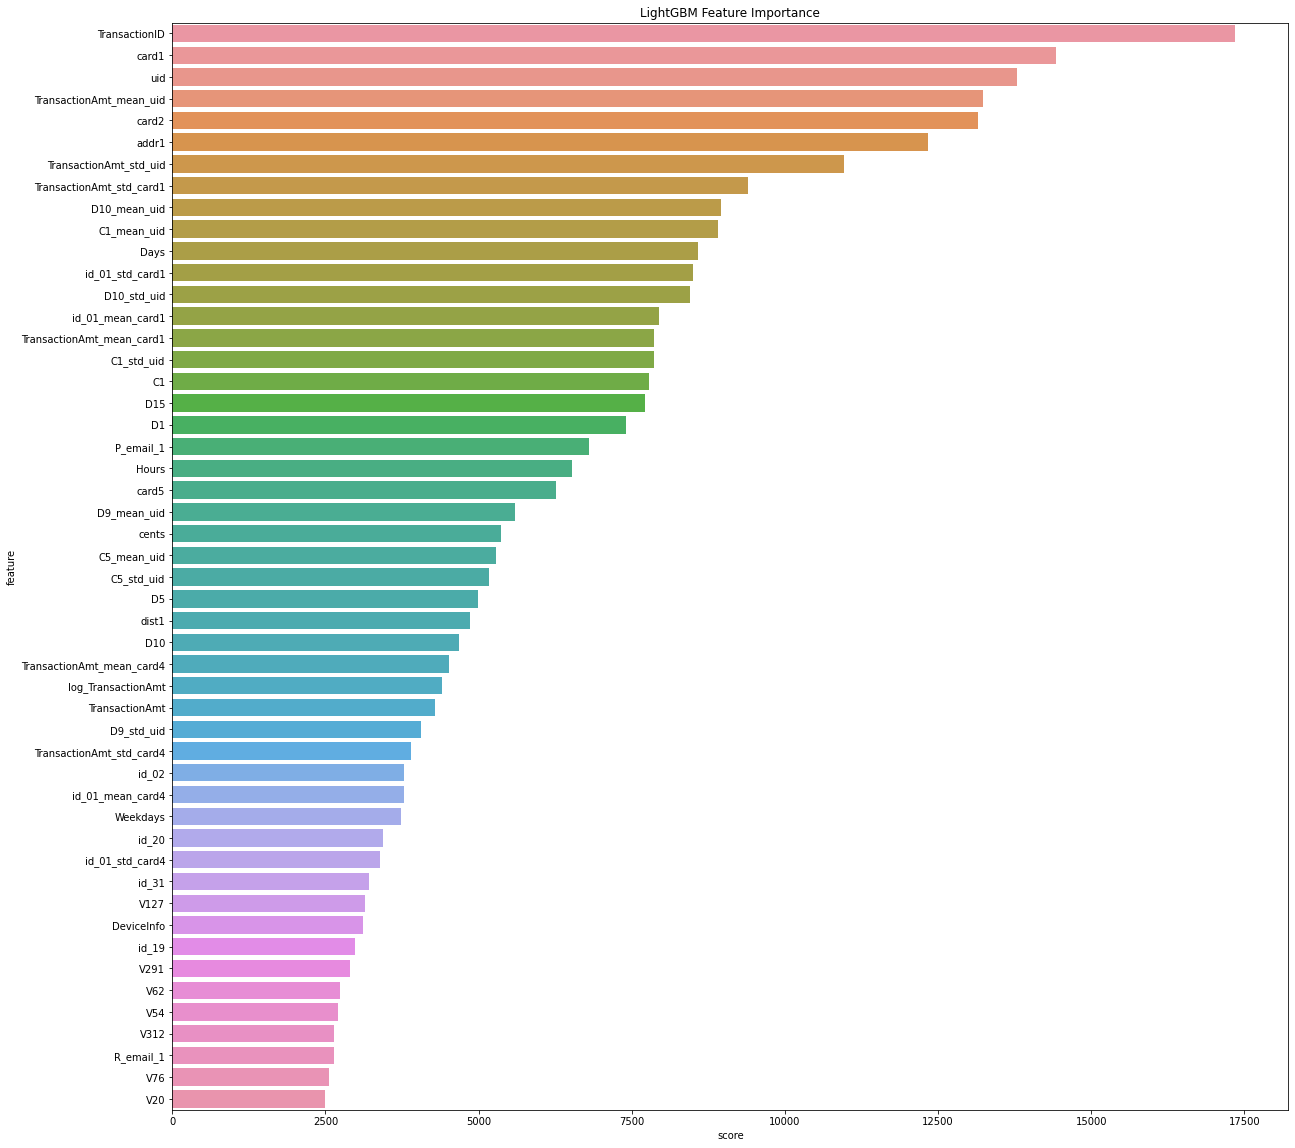

In [57]:
feat_imp = feature_importances[['feature']]
feat_imp['score'] = feature_importances.loc[:, [feat for feat in feature_importances.columns if feat != 'feature']].agg(['mean'], axis=1)

plt.figure(figsize=(20,20))
sns.barplot(x='score', y='feature', data=feat_imp.sort_values('score', ascending=False).iloc[:50])
plt.title('LightGBM Feature Importance')

In [58]:
sub = pd.read_csv('data/sample_submission.csv')
sub.isFraud = y_test_pred
sub.to_csv('sub_lgb.csv', index=False)